In [1]:
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras
import keras_tuner as kt
import datetime
import pathlib
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

2023-01-13 11:01:01.337013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 11:01:01.406932: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-13 11:01:01.425788: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-13 11:01:01.777186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

## getting dataset

In [2]:
data_dir = os.path.join("..", "cnn_preperation", "data")

In [3]:
batch_size = 64
img_height = int(720 / 4)
img_width = int(1280 / 4)

In [4]:
train_images_dir = os.path.join(data_dir, "train")
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_images_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_images_dir = os.path.join(data_dir, "val")
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_images_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_images_dir = os.path.join(data_dir, "test")
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_images_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
,)


Found 4800 files belonging to 4 classes.


2023-01-13 11:01:02.855491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-13 11:01:02.881211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-13 11:01:02.881252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-13 11:01:02.881670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

Found 1600 files belonging to 4 classes.
Found 1600 files belonging to 4 classes.


In [5]:
class_names = train_ds.class_names
print(class_names)

['hangloose', 'paper', 'rock', 'scissors']


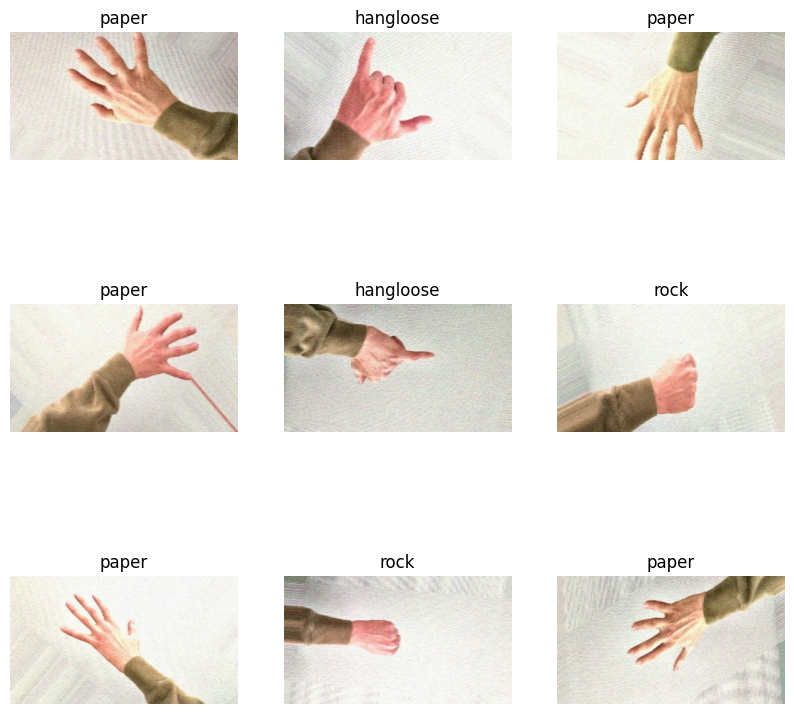

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)


In [10]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
def model_builder(hp):

    model = keras.Sequential()
    
    first_units = hp.Int('first_units', min_value=32, max_value=96, step=16)
#     first_units = hp.Int('first_units', min_value=32, max_value=64, step=32)
    
    model.add(keras.layers.Conv2D(first_units, (3, 3), input_shape = (img_height, img_width, 3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(2))    

    conv_layers = hp.Int('conv_layers', min_value=1, max_value=4, step=1)
    conv_kernels = hp.Int('conv_kernels', min_value=16, max_value=48, step=16)

    for i in range(conv_layers):
        model.add(keras.layers.Conv2D(conv_kernels, (3, 3), activation = 'relu'))
        model.add(keras.layers.MaxPooling2D(2))   
        
    minimum_pooling = 4
    
    pools_remaining = minimum_pooling -1 - conv_layers
    
    if pools_remaining > 0:
        for i in range(pools_remaining):
            model.add(keras.layers.MaxPooling2D(2))   

    
    
    model.add(keras.layers.Flatten())
    
    dense_layers = hp.Int('dense_layers', min_value=0, max_value=2, step=1)
    dense_neurons = hp.Int('dense_neurons', min_value=64, max_value=320, step=128)

#     dense_layers = 1
#     dense_neurons = 128
    
    for i in range(dense_layers):
        model.add(keras.layers.Dense(dense_neurons, activation = 'relu'))
        
    model.add(keras.layers.Dropout(0.25))
    
    
    model.add(keras.layers.Dense(len(class_names), activation = 'softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-3, 1e-4])
    
    optimizer=hp.Choice('optimizer', values=['adam', 'RMSprop'])

    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate)
    elif optimizer == 'adagrad':
        optimize = keras.optimizers.Adagrad(learning_rate=hp_learning_rate)
    elif optimizer == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    elif optimizer == 'RMSprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)

    
    model.compile(
 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="auto",
        name="sparse_categorical_crossentropy",),
    optimizer = optimizer, 
    
    metrics=['accuracy'])
    return model


In [12]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=27,
                     factor=3,
                     directory='kt_cnn',
                     project_name='cnnv4_10',
                    hyperband_iterations=2
                    )

In [13]:
logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir)

In [ ]:
tuner.search(train_ds,
             validation_data=val_ds,
             callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping('val_loss', patience=5)], 
             use_multiprocessing=True, 
             workers=20)


Search: Running Trial #69

Value             |Best Value So Far |Hyperparameter
48                |32                |first_units
1                 |4                 |conv_layers
32                |32                |conv_kernels
2                 |2                 |dense_layers
64                |320               |dense_neurons
0.0001            |0.001             |learning_rate
RMSprop           |adam              |optimizer
27                |27                |tuner/epochs
0                 |9                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/27
 6/75 [=>............................] - ETA: 5s - loss: 1.3947 - accuracy: 0.2344WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0225s vs `on_train_batch_end` time: 0.0522s). Check your callbacks.


75/75 [==============================] - 7s 84ms/step - loss: 1.3855 - accuracy: 0.2796 - val_loss: 1.3773 - val_accuracy: 0.3519
Epoch 2/27
75/75 [==============================] - 6s 80ms/step - loss: 1.3677 - accuracy: 0.3275 - val_loss: 1.3454 - val_accuracy: 0.4062
Epoch 3/27
75/75 [==============================] - 6s 80ms/step - loss: 1.3235 - accuracy: 0.3948 - val_loss: 1.2947 - val_accuracy: 0.4175
Epoch 4/27
75/75 [==============================] - 6s 79ms/step - loss: 1.2709 - accuracy: 0.4183 - val_loss: 1.2405 - val_accuracy: 0.4450
Epoch 5/27
75/75 [==============================] - 6s 78ms/step - loss: 1.2252 - accuracy: 0.4448 - val_loss: 1.2262 - val_accuracy: 0.4263
Epoch 6/27
75/75 [==============================] - 6s 79ms/step - loss: 1.1865 - accuracy: 0.4706 - val_loss: 1.1646 - val_accuracy: 0.4712
Epoch 7/27
75/75 [==============================] - 6s 79ms/step - loss: 1.1424 - accuracy: 0.4910 - val_loss: 1.1213 - val_accuracy: 0.5006
Epoch 8/27
75/75 [======

In [15]:
best_hps = tuner.get_best_hyperparameters()[0]
print(f"""

first_units: {best_hps.get('first_units')}.
learning_rate: {best_hps.get('learning_rate')}.
optimizer: {best_hps.get('optimizer')}.

""")



first_units: 32.
learning_rate: 0.001.
optimizer: adam.




In [16]:
tuner.search_space_summary()

best_model = tuner.get_best_models()[0]
best_model.summary()
best_model.evaluate(val_ds)

Search space summary
Default search space size: 7
first_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': None}
conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
conv_kernels (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 48, 'step': 16, 'sampling': None}
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
dense_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 320, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'RMSprop'], 'ordered': False}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #  

[0.11838988959789276, 0.9637500047683716]

In [17]:
tuner.results_summary()

Results summary
Results in kt_cnn/cnnv4_10
Showing 10 best trials
Trial summary
Hyperparameters:
first_units: 32
conv_layers: 4
conv_kernels: 32
dense_layers: 2
dense_neurons: 320
learning_rate: 0.001
optimizer: adam
tuner/epochs: 27
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0061
Score: 0.9637500047683716
Trial summary
Hyperparameters:
first_units: 32
conv_layers: 4
conv_kernels: 32
dense_layers: 2
dense_neurons: 320
learning_rate: 0.001
optimizer: adam
tuner/epochs: 9
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9412500262260437
Trial summary
Hyperparameters:
first_units: 64
conv_layers: 2
conv_kernels: 48
dense_layers: 2
dense_neurons: 320
learning_rate: 0.001
optimizer: RMSprop
tuner/epochs: 9
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9043750166893005
Trial summary
Hyperparameters:
first_units: 32
conv_layers: 3
conv_kernels: 48
dense_layers: 2
dense_neurons: 192
learning_rate: 0.0001
optimizer: adam
tuner/epochs:

In [18]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = best_model(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [19]:
cm = confusion_matrix(correct_labels, predicted_labels)

<AxesSubplot: >

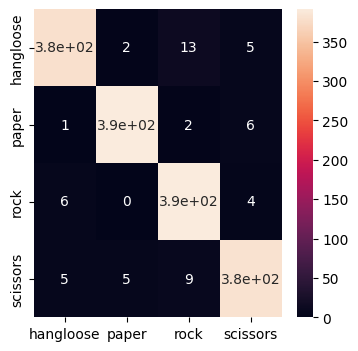

In [20]:
df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (len(class_names),len(class_names)))
sn.heatmap(df_cm, annot=True)

In [21]:
best_model.evaluate(val_ds)

25/25 [==============================] - 0s 17ms/step - loss: 0.1184 - accuracy: 0.9638


[0.11838988959789276, 0.9637500047683716]

In [22]:
best_model.save("best_model")

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets
